## Python Scripts:

###### I. Converting FASTA  to an appropriate format (Preparing the input)
###### II. Getting data from the web server
###### III. Plotting the results


##  Convertiong Fasta to Json: 

###### - The file.fasta is read line by line.
###### - If  a line starts with ">" and the var for protein sequence (here "cur_scaf") is empty then, it will be saved in a list as protein ID
###### - If a line does not start with ">" and the cur_scaf is not empty then, it will be saved in the cur_scaf as protein sequence inside a dict.
###### -If both conditions are false then, the content appends to the cur_scaf.
###### - The  json-format file is created from the dict using json module.


In [4]:
import json

def read_fasta(fileName):
    dic = {}
    cur_scaf = ''
    cur_seq = []
    for line in open(fileName):
        if line.startswith(">") and cur_scaf == '':
            cur_scaf = line[1:-1].split(' ')[0]
        elif line.startswith(">") and cur_scaf != '':
            dic[cur_scaf] = ''.join(cur_seq)
            cur_scaf = line[1:-1].split(' ')[0]
            cur_seq = []
        else:
            cur_seq.append(line.rstrip())
            dic[cur_scaf] = ''.join(cur_seq)
    return dic

def fasta2json(dic):
    """
    Read fasta-format file fil, return dict of form scaffold:sequence.
    """
    with open('output.json', 'w+') as outfile:
        json.dump(dic, outfile, indent=4)
    return dic

if __name__ == '__main__':
    dic = read_fasta("P53.fasta")

#dic = {'mySeq': "ENTERYERSEQENCEHEREPLEASECHANGE"}
results = fasta2json(dic)
print(results)


{'sp|P04637|P53_HUMAN': 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'}


## DisoMine
###### - A Json-format file as the input and loads it using the "json" module.
######  - Makes POST request with Json input body using "post" function. 
###### - Validates the response (Status 202 indicates that request has been accepted for processing)
######   - Makes GET request to check queue request status. 

In [13]:
import requests
import json
import time
WAIT_TIME = 5
TOTAL_TIME = 60
def getDataFromDisoMine():

    # Read input Json file
    file = open('P53.json', 'r')
    inputFile = file.read()
    request_json = json.dumps(json.loads(inputFile))
    request_json = request_json[:-1] + ', "extra_predictions":"true"}'
    
    # API Post URL
    post_url = "http://bio2byte.be/disomine/api/"

    # Make POST request with Json Input body
    # WV 190206 - ADDED the 'data =' in below for it to work on Python dictionary
    response = requests.post(post_url, json = request_json)
    
    queue_id = str(response.json()['queue_id'])
    
    # Validating Response Code
    assert response.status_code == 202
    
    print("Submitted with queue ID: {}...".format(queue_id))
        
    # Now get results - this will happen when results available or when time limit reached
    time_waited = 0    
    get_url = "http://bio2byte.be/disomine/api/queue/"
    
    while time_waited / TOTAL_TIME < 1.0:

      # Get Request
      response = requests.get(get_url + queue_id)
      
      if response.status_code == 202:
        print("  Waiting for results...")

      elif response.status_code == 200:
        queryResults = json.loads(response.text)
        break
       
      else:
        print("Server error, response {}.".format(response.status_code))
        break
      
      time.sleep(WAIT_TIME)
      time_waited += WAIT_TIME


    return queryResults
    
if __name__ == '__main__':
    results = getDataFromDisoMine()

# save the results to a json file
    json = json.dumps(results)
    f = open("Disomine_backbone_sidechain_efoldmine.json", "w")
    f.write(json)
    f.close()
    
print(results)

{'sp|P04637|P53_HUMAN': 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD'}
Submitted with queue ID: 238...
  Waiting for results...
  Waiting for results...
{'id': 228, 'results': [{'proteinID': 'P04637|P53_HUMAN Cellular tumor antigen', 'sequence': 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD', 'disomi

## DynaMine
######  The methods of the class: 
###### a. A json_api_key and a boolean flag for running status (_running) are defined in the constructor method.
###### b. submit_sequence: The method accepts the protein sequence and a boolean var for prediction status as the inputs and return a discription of the submitted job (job ID).  
###### c. submit_uniprot_ids: The method does the same thing as the submit_sequence but here, accepts the uniprot ID.  
###### d. submit_job: The method accepts the job dict which is just created. It uses the poll_results and  print_progress methods to:
######        -- Gives us a job ID.
######        -- Makes the call blocking until the results are ready
###### e. dynamine_request: This is the post request with the json encoding of the job. It uses urllib modules  
###### f. poll_results: The job ID is the input and return a discription of the submitted request.  
###### g. print_progress:  It accepts the status and flag as the inputs abd based on  the status of the request ('queued' , 'running' or 'completed' ) it:
######      -- Changes the state of the  '_running' boolean.
######     --  Gives the status while processing the request.

In [3]:
"""
Created by Elisa Cilia on 2014-08-20.
Copyright (c) 2014 Elisa Cilia. All rights reserved.
"""
import json
import urllib.request, urllib.parse, urllib.error
import time
import sys

# creating a JSON interface

class DynaMineJSONInterface:

    def __init__(self, json_api_key):
        self._running = False
        self._json_api_key = '3469626345366a923473c455fd6bb283621e70a3ba5428f301501f8a'

    def submit_sequences(self, proteins, predictions_only=True):
        job = {'protocol': '1.0',
               'json_api_key': self._json_api_key,
               'sequences': proteins,
               'predictions_only': predictions_only,
               }
        return self._submit_job(job)

    def submit_uniprot_ids(self, uniprot_ids, predictions_only=True):
        job = {'protocol': '1.0',
               'json_api_key': self._json_api_key,
               'uniprot_ids': uniprot_ids,
               'predictions_only': predictions_only,
               }
        return self._submit_job(job)

    def _submit_job(self, job):
        # response gives us a job_id
        response = self._dynamine_request(job)
        if response['status'] == 'error':
            sys.stderr.write(response['message'] + '\n')
            sys.exit(1)
        job_id = response['job_id']
        self._print_progress(response['status'], False)
        # this makes the call blocking until the results are ready
        while response['status'] != 'completed':
            time.sleep(1.5)
            response = self._poll_results(job_id)
            if response['status'] == 'error':
                sys.stderr.write(response['message'] + '\n')
                sys.exit(1)
            self._print_progress(response['status'], True)
        return response['results']

    def _dynamine_request(self, request):
        # this is the post request with the json encoding of the job
        data = urllib.parse.urlencode({'batch': json.dumps(request)}).encode("utf-8")
        url = 'http://dynamine.ibsquare.be/batch_request'
        response = ''

        req = urllib.request.Request(url, data)
        http_response = urllib.request.urlopen(req)
        response = json.loads(http_response.read())

        #response = {'status': 'error', 'message': 'Unable to communicate with the server.Please verify that %s is up and running, otherwise concact the server administrator (ERROR: %s).'}

        return response

    def _poll_results(self, job_id):
        request = {'protocol': '1.0',
                   'json_api_key': self._json_api_key,
                   'job_id': job_id
                   }
        return self._dynamine_request(request)

    def _print_progress(self, status, flag):
        if status == 'queued':
            if flag:
                sys.stdout.write('Waiting to be processed.\n')
            else:
                sys.stdout.write('The request has been submitted.\n')
            self._running = False
        elif status == 'running':
            if not self._running:
                self._running = True
                sys.stdout.write('The request is being processed...')
            else:
                sys.stdout.write('.')
        elif status == 'completed':
            if not self._running:
                sys.stdout.write('The request is being processed...')
            sys.stdout.write('done.\n')
        elif status == 'error':
            sys.stderr.write('\n\nError while processing the request:\n\n')
        sys.stdout.flush()


if __name__ == '__main__':
    json_api_key = 'd03e71ca849d3bc5277fd68e7a0f45124df5be84bf348db65218982f'
    dynamine = DynaMineJSONInterface(json_api_key)

    # Read input Json file
    file = open('output.json', 'r')
    inputFile = file.read()
    proteins = json.loads(inputFile)
    
results = dynamine.submit_sequences(proteins, predictions_only=False)
print(results)

# save the results to a json file
json = json.dumps(results)
f = open("dynamine_output.json", "w")
f.write(json)
f.close()

The request has been submitted.
The request is being processed...done.
{'url': 'http://dynamine.ibsquare.be/www/files/batch/dirb_6cde815cabc48bf7ba6e65b4567482c8/Dynamine_b_6cde815cabc48bf7ba6e65b4567482c8.zip', 'predictor': 'v 3.0', 'predictions': {'sp_P04637_P53_HUMAN': [['M', 0.384], ['E', 0.372], ['E', 0.385], ['P', 0.398], ['Q', 0.431], ['S', 0.46], ['D', 0.489], ['P', 0.505], ['S', 0.524], ['V', 0.545], ['E', 0.564], ['P', 0.586], ['P', 0.586], ['L', 0.608], ['S', 0.629], ['Q', 0.656], ['E', 0.685], ['T', 0.72], ['F', 0.758], ['S', 0.786], ['D', 0.811], ['L', 0.809], ['W', 0.812], ['K', 0.795], ['L', 0.782], ['L', 0.777], ['P', 0.759], ['E', 0.746], ['N', 0.747], ['N', 0.739], ['V', 0.742], ['L', 0.737], ['S', 0.73], ['P', 0.721], ['L', 0.723], ['P', 0.709], ['S', 0.707], ['Q', 0.708], ['A', 0.719], ['M', 0.751], ['D', 0.773], ['D', 0.765], ['L', 0.729], ['M', 0.709], ['L', 0.69], ['S', 0.695], ['P', 0.705], ['D', 0.724], ['D', 0.743], ['I', 0.734], ['E', 0.742], ['Q', 0.736], ['

## Plotting the results of DisoMine, DynaMine and EFoldMine
###### - A Json-format file as the input and loads it using the "json" module.
######  - Defines an index for each residue.
######  - Defines the corresponding scores of disomine, side chain dynamic, backbone dynamic and efold for each residue.
######  - Creats the plot using the matplotlib library.

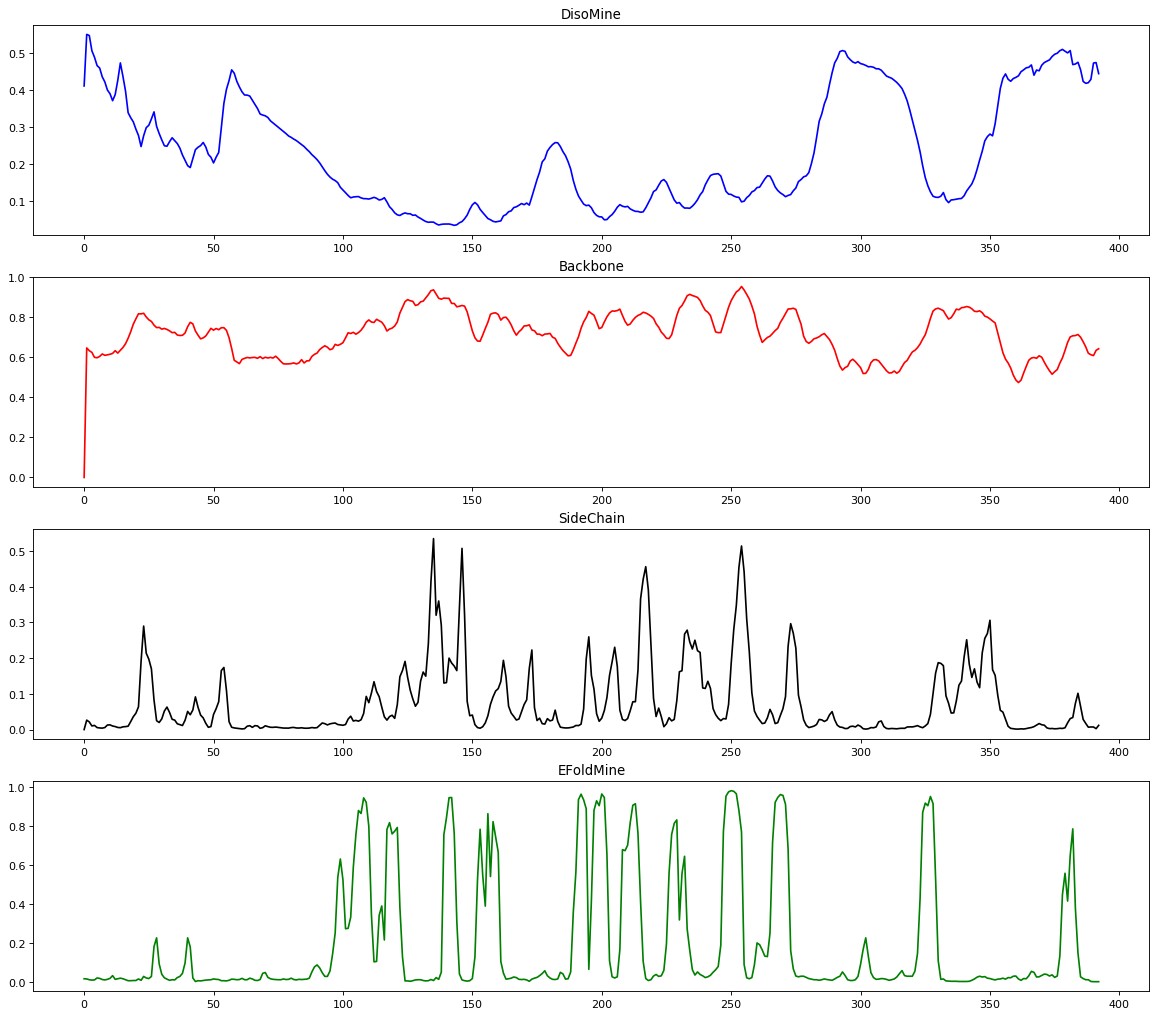

In [12]:
import matplotlib.pyplot as plt
import json

# Read input Json file
file = open('Disomine_backbone_sidechain_efoldmine.json', 'r')
input = file.read()
request_json = json.loads(input)

# residue index
seq = request_json["results"][0]['sequence']
#DisoMine Score
disomine = request_json["results"][0]['disomine']
#backbone Score
backbone = request_json["results"][0]['backbone']
#sidechain Score
sidechain = request_json["results"][0]['sidechain']
#efoldmine Score
efoldmine = request_json["results"][0]['efoldmine']
# creating a plot
fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

#ploting the DisoMine results
axes = fig.add_subplot(411)
axes.plot(range(len(seq)), disomine, color="b")
axes.set_title("DisoMine")

#ploting the Backbone results 
axes = fig.add_subplot(412)
axes.plot(range(len(seq)), backbone, color="r")
axes.set_title("Backbone")

#ploting the SideChain results
axes = fig.add_subplot(413)
axes.plot(range(len(seq)), sidechain, color="black")
axes.set_title("SideChain")

#ploting the EFoldMine results
axes = fig.add_subplot(414)
axes.plot(range(len(seq)), efoldmine, color="g")
axes.set_title("EFoldMine")

plt.show()


## Getting data from DEOGEN2

###### - The first function is for getting deogen2 sequence id from the uniprot id. 

###### - Defines the api-endpoint  and the data to be sent. 
###### - Make POST request with Input body 

In [11]:
import json
import requests
import re
from bs4 import BeautifulSoup

# A function for getting sequence id from sequence uniprot ID.
# You can enter the uniprot id of your preferred human protein sequence.  
def seq_uniprot_id2seq_id(seq_prefix):

    # Set the URL to webscrape from
    url = 'https://deogen2.mutaframe.com/sequence_finder.php?152539&sequence_prefix='+seq_prefix

    # Connect to the URL
    response = requests.get(url)

    # Parse HTML and save to BeautifulSoup object¶
    soup = BeautifulSoup(response.text, "html.parser")
    p = re.compile(r'data_sequence_id="\d\d\d\d\d')
    mo = p.search(str(soup.contents)).group()
    sequence_id = mo[18:]
    print(sequence_id)
    return sequence_id
     
seq_uniprot_id = 'P36897'
#seq_uniprot_id = '' # You may uncomment it and write the uniprot id of your preferred human protein.
seq_uniprot_id2seq_id(seq_uniprot_id )

# Getting data from DEOGEN2.
def getDataFromDEOGEN2(sequence_id, mutation):

    # defining the api-endpoint
    api_endpoint = "https://deogen2.mutaframe.com/fetch_results.php"

    # API key
    key = 1524214674089
    sequence_id = sequence_id
    mutation = mutation
    structure_id = 0

    # data to be sent to api
    data = {
        " ": key,
        "sequence_id": sequence_id,
        "mutation": mutation,
        "structure_id": structure_id,
    }

    # Make POST request with Input body
    response = requests.get(api_endpoint, data)
    queryResults = json.loads(response.text)
    return queryResults

if __name__ == '__main__':
    results = getDataFromDEOGEN2(64689, 'N45S')
    print(results)

64689
{'deogen2': {'prediction': 0.927375, 'features': {'provean': -3.31, 'conservation index': 0.22961454043687, 'probability': 2.0030685628953, 'early folding': -1.593, 'log-odd ratio': 1.7917594692281, 'interaction': 1, 'rvis': -0.271755481, 'gdi': 0.58837, 'recessiveness': 0.77849, 'essentiality': 1, 'pathway': 0}, 'contribution': {'provean': 0.14807462711912, 'conservation index': -0.067067377585845, 'probability': -0.037919316716986, 'early folding': 0.0024153921155141, 'log-odd ratio': 0.25393570735043, 'interaction': 0.0079703881307524, 'rvis': 0.019742243830915, 'gdi': 0.0343571916888, 'recessiveness': 0.10405744136885, 'essentiality': 0.05397585174286, 'pathway': -0.003693229465238}}, 'all_deogen2': {'R372K': '0.393271', 'R372I': '0.436919', 'R372H': '0.433734', 'R372N': '0.441193', 'R372M': '0.442047', 'R372L': '0.442549', 'R372C': '0.440055', 'R372A': '0.442438', 'R372G': '0.444239', 'R372F': '0.444239', 'R372E': '0.440353', 'R372D': '0.442805', 'R372Y': '0.445446', 'R372S'

## Plotting graph from DEOGEN2 Result 
###### - Accepts amino acid residue and number (e.g. R372) and the output file of DEOGEN2 (a Json-format file) as the inputs.
###### -  The file is loaded using the "json" module.
###### - Defines the scores for the DEOGEN2 Mutations  
###### - Creats the plot using the functins of the matplotlib library.

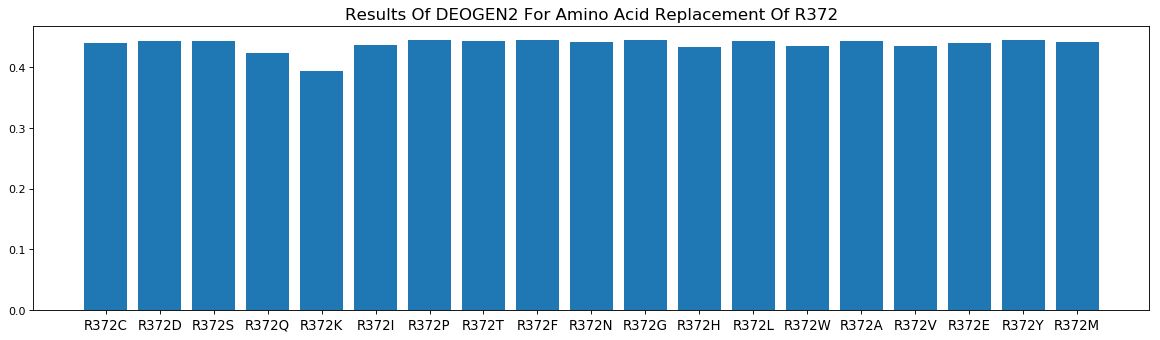

None


In [10]:
import matplotlib.pyplot as plt
import json

def deogen2plot(res):

    # Read input Json file
    file = open('DEOGEN2.json', 'r')
    input = file.read()
    request_json = json.loads(input)

    # mutation DEOGEN2 scores

    aa = 'CDSQKIPTFNGHLRWAVEYM'
    prediction = []
    mutations =[]
    for x in aa:
        if x != res[0]:
            df = request_json['all_deogen2'][res + x]
            prediction.append(df)
            mutations.append(res + x)

    deogen2 = [float(i) for i in prediction]

    # creating a plot

    fig = plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

    #ploting the DEOGEN2 results
    
    axes = fig.add_subplot(312)
    axes.bar(mutations, deogen2)
    plt.xticks(mutations, size = 12)
    axes.set_title("Results Of DEOGEN2 For Amino Acid Replacement Of " + res , size = 15)

    plt.show()

if __name__ == '__main__':
    results = deogen2plot('R372')
    print(results)
